In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from visualization.modules import Normalization
from visualization.style_transfer import *

Next, we need to choose which device to run the network on and import the
content and style images. Running the neural transfer algorithm on large
images takes longer and will go much faster when running on a GPU. We can
use ``torch.cuda.is_available()`` to detect if there is a GPU available.
Next, we set the ``torch.device`` for use throughout the tutorial. Also the ``.to(device)``
method is used to move tensors or modules to a desired device. 



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
print(device)

cuda


Loading the Images
------------------

Now we will import the style and content images. The original PIL images have values between 0 and 255, but when
transformed into torch tensors, their values are converted to be between
0 and 1. The images also need to be resized to have the same dimensions.
An important detail to note is that neural networks from the
torch library are trained with tensor values ranging from 0 to 1. If you
try to feed the networks with 0 to 255 tensor images, then the activated
feature maps will be unable sense the intended content and style.
However, pre-trained networks from the Caffe library are trained with 0
to 255 tensor images. 


.. Note::
    Here are links to download the images required to run the tutorial:
    `picasso.jpg <https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg>`__ and
    `dancing.jpg <https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg>`__.
    Download these two images and add them to a directory
    with name ``images`` in your current working directory.



In [5]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

path = "images/"
style_img = image_loader(path + "picasso.jpg")
content_img = image_loader(path + "dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

Now, let's create a function that displays an image by reconverting a 
copy of it to PIL format and displaying the copy using 
``plt.imshow``. We will try displaying the content and style images 
to ensure they were imported correctly.



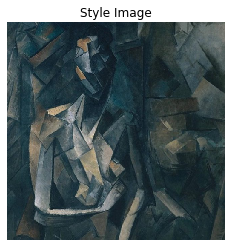

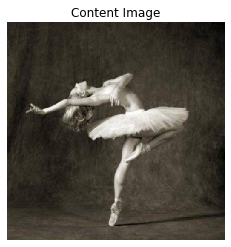

In [6]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, ax=None, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    if ax is None:
        ax = plt
        title_setter = plt.title
    else:
        title_setter = ax.set_title
    ax.imshow(image)
    ax.axis('off')
    if title is not None:
        title_setter(title)
    #plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

Importing the Model
-------------------

Now we need to import a pre-trained neural network. We will use a 19
layer VGG network like the one used in the paper.

PyTorch’s implementation of VGG is a module divided into two child
``Sequential`` modules: ``features`` (containing convolution and pooling layers),
and ``classifier`` (containing fully connected layers). We will use the
``features`` module because we need the output of the individual
convolution layers to measure content and style loss. Some layers have
different behavior during training than evaluation, so we must set the
network to evaluation mode using ``.eval()``.




In [7]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Additionally, VGG networks are trained on images with each channel
normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
We will use them to normalize the image before sending it into the network.




In [8]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
# class Normalization(nn.Module):
#     def __init__(self, mean, std):
#         super(Normalization, self).__init__()
#         # .view the mean and std to make them [C x 1 x 1] so that they can
#         # directly work with image Tensor of shape [B x C x H x W].
#         # B is batch size. C is number of channels. H is height and W is width.
#         self.mean = torch.tensor(mean).view(-1, 1, 1)
#         self.std = torch.tensor(std).view(-1, 1, 1)

#     def forward(self, img):
#         # normalize img
#         return (img - self.mean) / self.std

A ``Sequential`` module contains an ordered list of child modules. For
instance, ``vgg19.features`` contains a sequence (Conv2d, ReLU, MaxPool2d,
Conv2d, ReLU…) aligned in the right order of depth. We need to add our
content loss and style loss layers immediately after the convolution
layer they are detecting. To do this we must create a new ``Sequential``
module that has content loss and style loss modules correctly inserted.




In [9]:
arch = LayeredModule.from_cnn(cnn, Normalization(cnn_normalization_mean, cnn_normalization_std).to(device))

In [10]:
arch

LayeredModule(
  (layers): ModuleDict(
    (normalization-0): Normalization()
    (conv-0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu-0): ReLU()
    (conv-1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu-1): ReLU()
    (pool-0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv-2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu-2): ReLU()
    (conv-3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu-3): ReLU()
    (pool-1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv-4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu-4): ReLU()
    (conv-5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu-5): ReLU()
    (conv-6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu-6): ReLU()
    (conv-7): Conv2d(256, 256

In [11]:
style_injects = [f'conv-{i}' for i in range(5)]
content_injects = ['conv-3']

In [12]:
style_module = StyleTransferModule(arch, content_img, content_injects, style_img, style_injects)

In [13]:
style_module

StyleTransferModule(
  (layers): ModuleDict(
    (normalization-0): Normalization()
    (conv-0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss-0): StyleLoss()
    (relu-0): ReLU()
    (conv-1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss-1): StyleLoss()
    (relu-1): ReLU()
    (pool-0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv-2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss-2): StyleLoss()
    (relu-2): ReLU()
    (conv-3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss-3): StyleLoss()
    (content_loss-3): ContentLoss()
    (relu-3): ReLU()
    (pool-1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv-4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss-4): StyleLoss()
  )
)

In [14]:
len(style_module.layers)

18

In [15]:
[m.target.sum() for m in style_module.layers.values() if isinstance(m, StyleLoss)]

[tensor(1.0366, device='cuda:0'),
 tensor(12.5292, device='cuda:0'),
 tensor(60.4034, device='cuda:0'),
 tensor(226.1362, device='cuda:0'),
 tensor(718.5371, device='cuda:0')]

In [16]:
[m.target.sum() for m in style_module.layers.values() if isinstance(m, ContentLoss)]

[tensor(-9310236., device='cuda:0')]

Next, we select the input image. You can use a copy of the content image
or white noise.




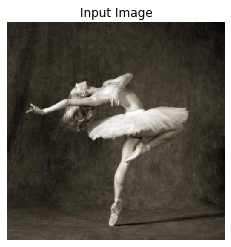

In [17]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

Gradient Descent
----------------

As Leon Gatys, the author of the algorithm, suggested `here <https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq>`__, we will use
L-BFGS algorithm to run our gradient descent. Unlike training a network,
we want to train the input image in order to minimise the content/style
losses. We will create a PyTorch L-BFGS optimizer ``optim.LBFGS`` and pass
our image to it as the tensor to optimize.




Finally, we must define a function that performs the neural transfer. For
each iteration of the networks, it is fed an updated input and computes
new losses. We will run the ``backward`` methods of each loss module to
dynamicaly compute their gradients. The optimizer requires a “closure”
function, which reevaluates the modul and returns the loss.

We still have one final constraint to address. The network may try to
optimize the input with values that exceed the 0 to 1 tensor range for
the image. We can address this by correcting the input values to be
between 0 to 1 each time the network is run.




Finally, we can run the algorithm.




Optimizing...
run [50]:
Style Loss : 3.997845 Content Loss: 4.192600

run [100]:
Style Loss : 1.156751 Content Loss: 3.063287

run [150]:
Style Loss : 0.711016 Content Loss: 2.659754

run [200]:
Style Loss : 0.479033 Content Loss: 2.503976

run [250]:
Style Loss : 0.345082 Content Loss: 2.411757

run [300]:
Style Loss : 0.264970 Content Loss: 2.359149



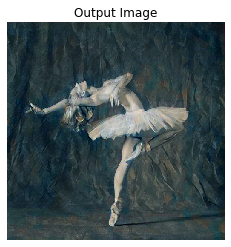

In [18]:
# output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
#                             content_img, style_img, input_img, num_steps=600)

output = style_module.run_style_transfer(input_img, num_steps=300)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

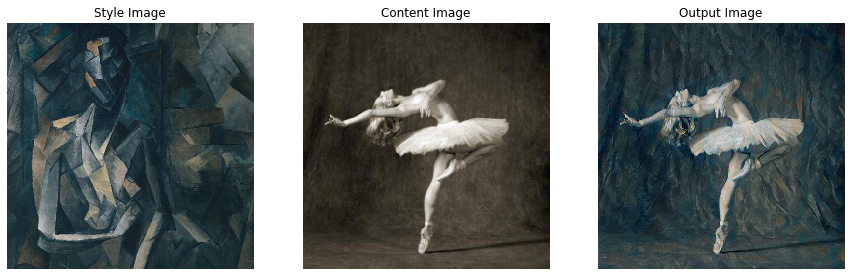

In [19]:
_, ax = plt.subplots(1, 3, figsize=(15,6))
imshow(style_img, title='Style Image', ax=ax[0])
imshow(content_img, title='Content Image', ax=ax[1])
imshow(output, title='Output Image', ax=ax[2])